The exploratory analysis will be based on our goal and objectives.

*Primary goal* 

Analyze the factors influencing COVID-19 cases and death rates across age groups by examining the vaccination statuses, 
and the community transmission levels. 

*Objectives*

Analyze the Impact of Vaccination Status on Infection and Mortality Rates.

Assess the Influence of Community Transmission Levels.

Identify Geographic disparities.

Develop Data-Driven Public Health Recommendations.

In [5]:
import sqlite3
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

**CREATE THE DATABASE SQL_data.db**

In [11]:
# Print clean columns for the two datasets
clean = pd.read_csv("Data/clean/clean_data_small.csv")
clean.columns

Index(['outcome', 'month', 'Age group', 'Vaccinated with outcome',
       'Unvaccinated with outcome'],
      dtype='object')

In [10]:
clean = pd.read_csv("Data/clean/clean_data_small_2.csv")
clean.columns

Index(['state_name', 'date', 'community_transmission_level'], dtype='object')

In [12]:
# Name the table
Covid_rates_columns = ['outcome', 'month', 'Age group', 'Vaccinated with outcome',
       'Unvaccinated with outcome'
    
]

trans_level_columns = ['state_name', 'date', 'community_transmission_level'
    
]

# Create empty DataFrames
Covid_rates = pd.DataFrame(columns=Covid_rates_columns)
trans_level = pd.DataFrame(columns=trans_level_columns)

# Load the CSV files into pandas DataFrames
Covid_rates = pd.read_csv("Data/clean/clean_data_small.csv")
trans_level = pd.read_csv("Data/clean/clean_data_small_2.csv")


# Define the file path for the SQLite database
db_path = "SQL_data2.db"

# Create SQLite database and save tables
conn = sqlite3.connect("SQL_data2.db")

# Save data into tables
Covid_rates.to_sql('Covid_rates', conn, index=False, if_exists='replace')
trans_level.to_sql('trans_level', conn, index=False, if_exists='replace')

# Close the database connection
# conn.close()
print(f"Database created and loaded with data from CSV files at {db_path}")

Database created and loaded with data from CSV files at SQL_data2.db


In [13]:
# fetch data from the tables
Covid_rates = pd.read_sql_query("SELECT * FROM Covid_rates LIMIT 5;", conn)
print("First 5 rows from Covid_rates table:")
print(Covid_rates)

trans_level = pd.read_sql_query("SELECT * FROM trans_level LIMIT 5;", conn)
print("First 5 rows from trans_level table:")
print(trans_level)

# Close the connection when done
conn.close()

First 5 rows from Covid_rates table:
  outcome     month Age group  Vaccinated with outcome  \
0    case  APR 2021     12-17                        8   
1    case  APR 2021     18-29                      674   
2    case  APR 2021     30-49                     1847   
3    case  APR 2021     50-64                     1558   
4    case  APR 2021     65-79                     1672   

   Unvaccinated with outcome  
0                      30785  
1                      76736  
2                      98436  
3                      50324  
4                      14880  
First 5 rows from trans_level table:
  state_name        date community_transmission_level
0      Texas  01/27/2020                         high
1   Nebraska  01/27/2020                         high
2   Illinois  01/27/2020                         high
3       Iowa  01/27/2020                         high
4  Tennessee  02/05/2020                          low


In [14]:
source = "SQL_data2.db"
destination = "Data/"
shutil.move(source, destination)

'Data/SQL_data2.db'

**DISTRIBUTION OF Covid-19 CASES BY AGE GROUP BETWEEN VACCINATED AND UNVACCINATED**

In [15]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data2.db')

#Calculate age group using the sql
query = ("""

SELECT 
    [Age group], 
    SUM(CASE WHEN outcome = 'case' THEN [Vaccinated with outcome] ELSE 0 END) AS Vaccinated_Cases,
    SUM(CASE WHEN outcome = 'case' THEN [Unvaccinated with outcome] ELSE 0 END) AS Unvaccinated_Cases,
    SUM(CASE WHEN outcome = 'case' THEN [Vaccinated with outcome] + [Unvaccinated with outcome] ELSE 0 END) AS Total_Cases
FROM Covid_rates
GROUP BY [Age group]
ORDER BY Total_Cases DESC;
""")

# Run the query and load results into a DataFrame
cases_by_age_group = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Print the result using tabulate
print(tabulate(cases_by_age_group, headers='keys', tablefmt='grid', showindex=False))

+--------------+--------------------+----------------------+---------------+
| Age group    |   Vaccinated_Cases |   Unvaccinated_Cases |   Total_Cases |
+==============+====================+======================+===============+
| all_ages_adj |           35736157 |             83788412 |     119524569 |
+--------------+--------------------+----------------------+---------------+
| 30-49        |            6037254 |              6934922 |      12972176 |
+--------------+--------------------+----------------------+---------------+
| 18-29        |            3235323 |              5060862 |       8296185 |
+--------------+--------------------+----------------------+---------------+
| 50-64        |            4071401 |              3246103 |       7317504 |
+--------------+--------------------+----------------------+---------------+
| 65-79        |            2336144 |              1365175 |       3701319 |
+--------------+--------------------+----------------------+---------------+

The data reveals the distribution of COVID-19 cases by age group, distinguishing between vaccinated and unvaccinated individuals:

all_ages_adj: Across all age groups, there were approximately 119.5 million cases, with 83.8 million (or about 70% of total cases) unvaccinated cases; while vaccinated cases totaled 35.7 million.

30-49 age group: most affected age group with the highest number of cases (12.97 million total), reflecting a significant portion of the population that is both socially active and potentially less likely to be vaccinated.

18-29 and 12-17 age groups combined account for 11.6 million cases, indicating considerable infection rates among younger populations, particularly the unvaccinated.

65-79 and 80+: reported fewer cases compared to younger groups, likely due to higher vaccination rates and more precautions taken.

Children (5-11): fewer cases (2.06 million) compared to other age groups, possibly reflecting lower transmission rates and/or vaccine availability for children.

Summery: Higher risk of infection among unvaccinated individuals across all age groups and significant contributions of younger, socially active groups to the case.

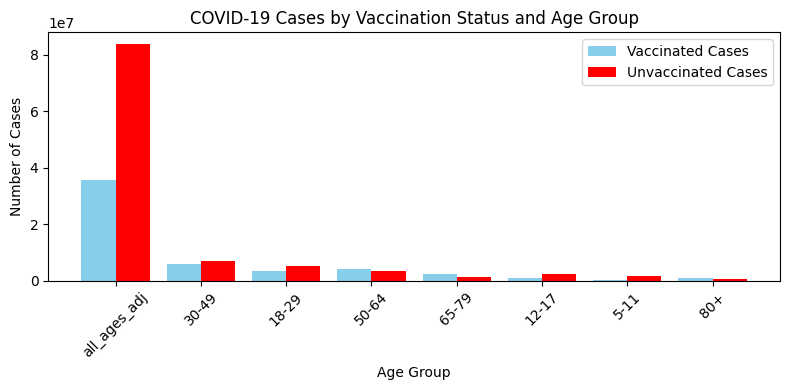

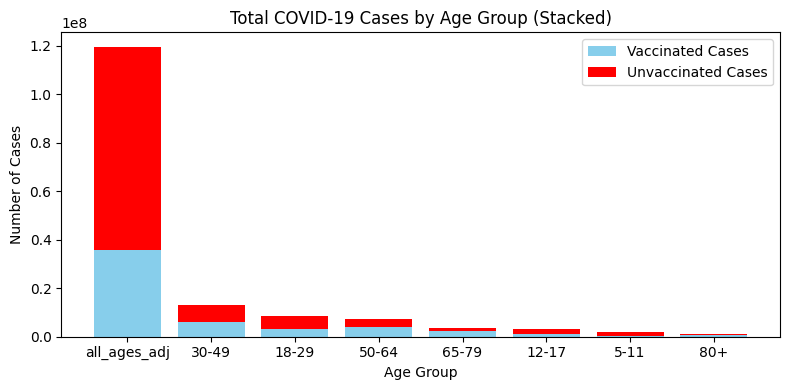

In [16]:
# Define Data for vizualization
data = {
    "Age group": ["all_ages_adj", "30-49", "18-29", "50-64", "65-79", "12-17", "5-11", "80+"],
    "Vaccinated_Cases": [35736157, 6037254, 3235323, 4071401, 2336144, 1064817, 374167, 758672],
    "Unvaccinated_Cases": [83788412, 6934922, 5060862, 3246103, 1365175, 2244912, 1687598, 407531],
    "Total_Cases": [119524569, 12972176, 8296185, 7317504, 3701319, 3309729, 2061765, 1166203],
}

df = pd.DataFrame(data)

# Set positions for bars
x = np.arange(len(df["Age group"]))

# Bar chart: Vaccinated vs. Unvaccinated Cases
plt.figure(figsize=(8, 4))
bar_width = 0.4
plt.bar(x - bar_width/2, df["Vaccinated_Cases"], width=bar_width, label="Vaccinated Cases", color="skyblue")
plt.bar(x + bar_width/2, df["Unvaccinated_Cases"], width=bar_width, label="Unvaccinated Cases", color="red")
plt.xticks(x, df["Age group"], rotation=45)
plt.xlabel("Age Group")
plt.ylabel("Number of Cases")
plt.title("COVID-19 Cases by Vaccination Status and Age Group")
plt.legend()
plt.tight_layout()
plt.show()

# Total Cases
plt.figure(figsize=(8, 4))
plt.bar(df["Age group"], df["Vaccinated_Cases"], label="Vaccinated Cases", color="skyblue")
plt.bar(df["Age group"], df["Unvaccinated_Cases"], bottom=df["Vaccinated_Cases"], label="Unvaccinated Cases", color="red")
plt.xlabel("Age Group")
plt.ylabel("Number of Cases")
plt.title("Total COVID-19 Cases by Age Group (Stacked)")
plt.legend()
plt.tight_layout()
plt.show()

**DISTRIBUTION OF Covid-19 CASES BY AGE GROUP BETWEEN VACCINATED AND UNVACCINATED**

In [17]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data2.db')

# Calculate deaths by age group using SQL query
query = """
SELECT 
    [Age group], 
    SUM(CASE WHEN outcome = 'death' THEN [Vaccinated with outcome] ELSE 0 END) AS Vaccinated_Deaths,
    SUM(CASE WHEN outcome = 'death' THEN [Unvaccinated with outcome] ELSE 0 END) AS Unvaccinated_Deaths,
    SUM(CASE WHEN outcome = 'death' THEN [Vaccinated with outcome] + [Unvaccinated with outcome] ELSE 0 END) AS Total_Deaths
FROM Covid_rates
GROUP BY [Age group]
ORDER BY Total_Deaths ASC;
"""

# Execute the query and load results into a DataFrame
deaths_by_age_group = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Convert the DataFrame to a list of lists for tabulate
##data = deaths_by_age_group.values.tolist()

# Define column headers
##headers = deaths_by_age_group.columns.tolist()

# Print the result using tabulate
print(tabulate(deaths_by_age_group, headers='keys', tablefmt='grid', showindex=False))

# Display the result using tabulate
#print(tabulate(data, headers=headers, tablefmt="grid"))

# Display the result
#print(deaths_by_age_group)

+--------------+---------------------+-----------------------+----------------+
| Age group    |   Vaccinated_Deaths |   Unvaccinated_Deaths |   Total_Deaths |
+==============+=====================+=======================+================+
| 5-11         |                   3 |                    46 |             49 |
+--------------+---------------------+-----------------------+----------------+
| 12-17        |                  27 |                   183 |            210 |
+--------------+---------------------+-----------------------+----------------+
| 18-29        |                 210 |                  2487 |           2697 |
+--------------+---------------------+-----------------------+----------------+
| 30-49        |                2277 |                 21013 |          23290 |
+--------------+---------------------+-----------------------+----------------+
| 50-64        |               10328 |                 49229 |          59557 |
+--------------+---------------------+--

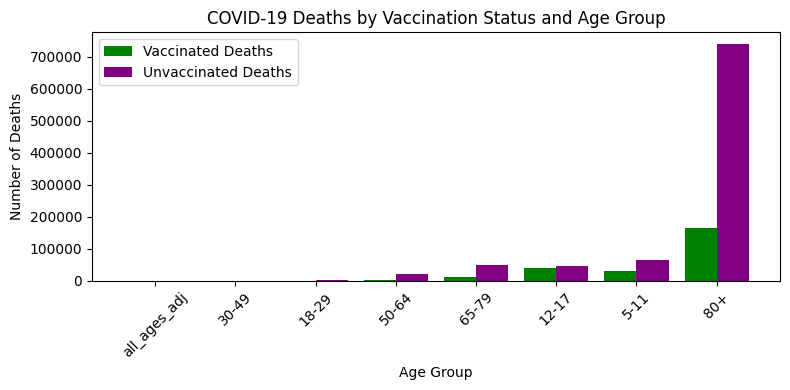

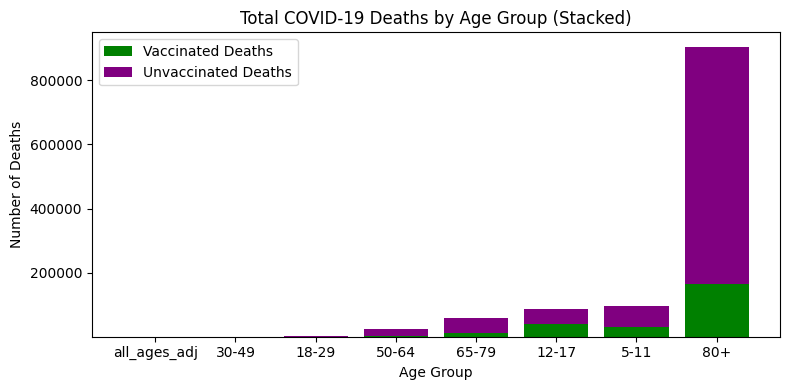

In [18]:
# Define Data for visualization
data = {
    "Age group": ["all_ages_adj", "30-49", "18-29", "50-64", "65-79", "12-17", "5-11", "80+"],
    "Vaccinated_Deaths": [3, 27, 210, 2277, 10328, 39438, 30248, 164958],
    "Unvaccinated_Deaths": [46, 183, 2487, 21013, 49229, 46355, 65686, 739996],
    "Total_Deaths": [49, 210, 2697, 23290, 59557, 85793, 95934, 904954],
}

df = pd.DataFrame(data)

# Set positions for bars
x = np.arange(len(df["Age group"]))

# Bar chart: Vaccinated vs. Unvaccinated Cases
plt.figure(figsize=(8, 4))
bar_width = 0.4
plt.bar(x - bar_width/2, df["Vaccinated_Deaths"], width=bar_width, label="Vaccinated Deaths", color="green")
plt.bar(x + bar_width/2, df["Unvaccinated_Deaths"], width=bar_width, label="Unvaccinated Deaths", color="purple")
plt.xticks(x, df["Age group"], rotation=45)
plt.xlabel("Age Group")
plt.ylabel("Number of Deaths")
plt.title("COVID-19 Deaths by Vaccination Status and Age Group")
plt.legend()
plt.tight_layout()
plt.show()

# Stacked Bar Chart: Total Cases
plt.figure(figsize=(8, 4))
plt.bar(df["Age group"], df["Vaccinated_Deaths"], label="Vaccinated Deaths", color="green")
plt.bar(df["Age group"], df["Unvaccinated_Deaths"], bottom=df["Vaccinated_Deaths"], label="Unvaccinated Deaths", color="purple")
plt.xlabel("Age Group")
plt.ylabel("Number of Deaths")
plt.title("Total COVID-19 Deaths by Age Group (Stacked)")
plt.legend()
plt.tight_layout()
plt.show()

**Total COVID-19 deaths by vaccination status and age group.**

There is a disparity between vaccinated and unvaccinated populations.
About 905,000 deaths occurred across all age groups, with 82% (739,996) among unvaccinated individuals.
The 65-79 and 80+ age groups were at the highest death tolls (95,934 and 85,793 deaths, respectively), driven primarily by unvaccinated individuals.
Deaths among children and adolescents (5-11, and 12-17 years) were minimal, 259 deaths.
Summery (importance of vaccination): Deaths among vaccinated individuals were consistently lower across all age groups, 
reflecting vaccine effectiveness in reducing mortality.

**LEVEL OF TRANSMISSION BY DATE AND STATE**

In [24]:
trans_level = pd.read_csv("Data/clean/clean_data_small_2.csv")

#Connect to SQLite database
conn = sqlite3.connect('SQL_data2.db')

# Execute the query
query = """
SELECT 
    state_name, 
    date, 
    community_transmission_level, 
    COUNT(*) AS level_count
FROM 
    trans_level
    GROUP BY 
    state_name, date, community_transmission_level
ORDER BY 
    date, state_name;
"""
data = pd.read_sql(query, conn)
conn.close()

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# 1. **Heatmap**: State vs. Date with Transmission Level
heatmap_data = data.pivot_table(
    index='state_name', 
    columns='date', 
    values='level_count', 
    aggfunc='sum'
)

plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, cmap='coolwarm', linewidths=0.5)
plt.title("Community Transmission Levels by State and Date", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.show()

DatabaseError: Execution failed on sql '
SELECT 
    state_name, 
    date, 
    community_transmission_level, 
    COUNT(*) AS level_count
FROM 
    trans_level_columns
    GROUP BY 
    state_name, date, community_transmission_level
ORDER BY 
    date, state_name;
': no such table: trans_level_columns

In [58]:
# Check for rows where conversion failed (NaT values)
print(Covid_rates[Covid_rates['date'].isna()])
print(trans_level[trans_level['date'].isna()])

  outcome date  MMWR week Age group Vaccine product  Vaccinated with outcome  \
0    case  NaT     202114     12-17       all_types                        8   
1    case  NaT     202114     18-29       all_types                      674   
2    case  NaT     202114     30-49       all_types                     1847   
3    case  NaT     202114     50-64       all_types                     1558   
4    case  NaT     202114     65-79       all_types                     1672   

   Fully vaccinated population  Unvaccinated with outcome  \
0                      36887.0                      30785   
1                    2543093.0                      76736   
2                    7428405.0                      98436   
3                    7487444.0                      50324   
4                   14398099.0                      14880   

   Unvaccinated population  Crude vax IR  Crude unvax IR  Crude IRR  \
0               17556462.0     21.687858      175.348541   8.085102   
1         

In [100]:
# Fill NaT values with a default date using direct assignment
Covid_rates['date'] = Covid_rates['date'].fillna('04/2021')
trans_level['date'] = trans_level['date'].fillna('01/2020')

Covid_rates['date'] = pd.to_datetime(Covid_rates['date']).dt.strftime('%m/%Y')
trans_level['date'] = pd.to_datetime(trans_level['date']).dt.strftime('%m/%Y')

# Check the final result
print(Covid_rates[['date']].head())
print(trans_level[['date']].head())

      date
0  04/2021
1  04/2021
2  04/2021
3  04/2021
4  04/2021
      date
0  01/2020
1  01/2020
2  01/2020
3  01/2020
4  01/2020


In [63]:
# Merge the datasets on the 'date' columns
merged_data = pd.merge(Covid_rates, trans_level, on=['date'], how='left')
                    
print(merged_data.head())

  outcome     date  MMWR week Age group Vaccine product  \
0    case  04/2021     202114     12-17       all_types   
1    case  04/2021     202114     18-29       all_types   
2    case  04/2021     202114     30-49       all_types   
3    case  04/2021     202114     50-64       all_types   
4    case  04/2021     202114     65-79       all_types   

   Vaccinated with outcome  Fully vaccinated population  \
0                        8                      36887.0   
1                      674                    2543093.0   
2                     1847                    7428405.0   
3                     1558                    7487444.0   
4                     1672                   14398099.0   

   Unvaccinated with outcome  Unvaccinated population  Crude vax IR  \
0                      30785               17556462.0     21.687858   
1                      76736               31091322.0     26.503160   
2                      98436               41074337.0     24.864019   
3     

In [69]:
print(merged_data.shape)

(5, 19)


In [70]:
merged_data.isnull().sum()

outcome                                               0
date                                                  0
MMWR week                                             0
Age group                                             0
Vaccine product                                       0
Vaccinated with outcome                               0
Fully vaccinated population                           0
Unvaccinated with outcome                             0
Unvaccinated population                               0
Crude vax IR                                          0
Crude unvax IR                                        0
Crude IRR                                             0
Continuity correction                                 0
state_name                                            5
county_name                                           5
fips_code                                             5
cases_per_100K_7_day_count_change                     5
percent_test_results_reported_positive_last_7_da

In [86]:
merged_data.describe()

,MMWR week,Vaccinated with outcome,Fully vaccinated population,Unvaccinated with outcome,Unvaccinated population,Crude vax IR,Crude unvax IR,Crude IRR,Continuity correction,fips_code,cases_per_100K_7_day_count_change,percent_test_results_reported_positive_last_7_days
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
merged_data.duplicated().sum()

np.int64(0)

In [78]:
merged_data.head(5)

,outcome,date,MMWR week,Age group,Vaccine product,Vaccinated with outcome,Fully vaccinated population,Unvaccinated with outcome,Unvaccinated population,Crude vax IR,Crude unvax IR,Crude IRR,Continuity correction,state_name,county_name,fips_code,cases_per_100K_7_day_count_change,percent_test_results_reported_positive_last_7_days,community_transmission_level
